In [22]:
import os, sys, math, pickle, time
from zmqRemoteApi import RemoteAPIClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from random import randint as ri
from random import uniform as ru

from keras.models import Sequential
from keras.layers import Dense
from keras.losses import Huber
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [23]:
path = os.getcwd()
data_folder = "\\training_data"
scene = "modular02c"
file_list = os.listdir(path + data_folder)
file_list

['2023_2510',
 '2023_3010',
 'joined_training_dataset_modular02a_2023_3010.pkl',
 'joined_training_dataset_modular02b_2023_3010.pkl',
 'joined_training_dataset_modular02c_2023_3010.pkl',
 'joined_training_dataset_modular03_2023_3010.pkl']

In [24]:
scene_files_list = [item for item in file_list if scene in item and "pkl" in item]
scene_files_list

['joined_training_dataset_modular02c_2023_3010.pkl']

In [10]:
path = os.getcwd() + "\\training_data"
scene = "modular02c"
file_list = os.listdir(path)
scene_files_list = [item for item in file_list if scene in item and "pkl" in item]


file = open(path + "\\" + scene_files_list[0], "rb")
training_data = pickle.load(file)
training_df = pd.DataFrame(training_data)
training_df

,sequence,step,increments,prev_j_positions,prev_pos_x,prev_pos_y,prev_pos_z,post_j_positions,post_pos_x,post_pos_y,post_pos_z,delta_pos_x,delta_pos_y,delta_pos_z
0,0,0,"[0.042873655649116334, -0.03314261671987426]","[-7.62939453125e-06, -2.1457672119140625e-06]",0.027115,0.000000,0.000000,"[0.04273080825805664, -0.032869577407836914]",-0.044798,-0.092643,0.028681,-0.071913,-0.092643,2.868070e-02
1,0,1,"[-0.08003858196980072, 0.031209503225758693]","[0.04273080825805664, -0.032869577407836914]",-0.044798,-0.092643,0.028681,"[-0.03708243370056152, -0.0017559528350830078]",-0.044427,-0.092449,0.027534,0.000371,0.000194,-1.146756e-03
2,0,2,"[0.08759296433658013, -0.053361943360938]","[-0.03708243370056152, -0.0017559528350830078]",-0.044427,-0.092449,0.027534,"[0.05001521110534668, -0.054868459701538086]",-0.044615,-0.092692,0.029394,-0.000188,-0.000243,1.860475e-03
3,0,3,"[0.030858189122999882, 0.01594416347988449]","[0.05001521110534668, -0.054868459701538086]",-0.044615,-0.092692,0.029394,"[0.08094239234924316, -0.03911995887756348]",-0.044444,-0.092715,0.029611,0.000170,-0.000023,2.163369e-04
4,0,4,"[0.08580356387766504, 0.07341136775623207]","[0.08094239234924316, -0.03911995887756348]",-0.044444,-0.092715,0.029611,"[0.16689276695251465, 0.033972978591918945]",-0.044910,-0.091902,0.030931,-0.000465,0.000812,1.320116e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,19,95,"[0.07510397167676472, -0.02144222855553906]","[1.3416492938995361, 0.42046093940734863]",-0.089754,-0.073713,0.030501,"[1.4250199794769287, 0.4006214141845703]",-0.089915,-0.073601,0.030501,-0.000161,0.000112,-2.980232e-08
1996,19,96,"[0.12799749989290451, 0.006634490204103662]","[1.4250199794769287, 0.4006214141845703]",-0.089915,-0.073601,0.030501,"[1.5614607334136963, 0.4082965850830078]",-0.089851,-0.073635,0.030501,0.000064,-0.000035,-3.352761e-08
1997,19,97,"[0.012986463584368398, 0.05862661900799767]","[1.5614607334136963, 0.4082965850830078]",-0.089851,-0.073635,0.030501,"[1.570789098739624, 0.4676964282989502]",-0.089471,-0.073802,0.030501,0.000380,-0.000167,-2.123415e-07
1998,19,98,"[0.10540129482106207, -0.003750243370762401]","[1.570789098739624, 0.4676964282989502]",-0.089471,-0.073802,0.030501,"[1.5707929134368896, 0.46552515029907227]",-0.089483,-0.073807,0.030501,-0.000012,-0.000005,3.352761e-07


In [25]:
#Function to split the training data into X,y datasets
def load_dataset(scene_in = "modular02a"):
    # Defining usefull variables
    path = os.getcwd() + "\\training_data"
    file_list = os.listdir(path)
    scene_files_list = [item for item in file_list if scene_in in item and "pkl" in item]


    file = open(path + "\\" + scene_files_list[0], "rb")
    training_data = pickle.load(file)
    training_df = pd.DataFrame(training_data)
    training_df

    #List to store the name for every joint data column
    increments_columns = []
    prev_j_positions_columns = []
    post_j_positions_columns = []

    #Creates the name for every column
    num_joints = len(training_data[-1]["increments"])
    for joint_n in range(num_joints):
        #List to split inputs per joint
        joint_inc_col_name = "increments_" + str(joint_n)
        increments_columns.append(joint_inc_col_name)

        prev_joint_pos_col_name = "prev_j_positions_" + str(joint_n)
        prev_j_positions_columns.append(prev_joint_pos_col_name)

        #List to split outputs per joint
        post_joint_pos_col_name = "post_j_positions_" + str(joint_n)
        post_j_positions_columns.append(post_joint_pos_col_name)

    #Input columns per joint
    increments_df = pd.DataFrame(training_df['increments'].to_list())
    increments_df.columns = increments_columns
    prev_j_positions_df = pd.DataFrame(training_df['prev_j_positions'].to_list())
    prev_j_positions_df.columns = prev_j_positions_columns

    X_df = pd.concat([increments_df, prev_j_positions_df, 
                    training_df["prev_pos_x"], training_df["prev_pos_y"], training_df["prev_pos_z"]], 
                    axis="columns")

    #Output columns per joint
    post_j_positions_df = pd.DataFrame(training_df['post_j_positions'].to_list())
    post_j_positions_df.columns = post_j_positions_columns


    y_df = pd.concat([post_j_positions_df, 
                    training_df["post_pos_x"], training_df["post_pos_y"], training_df["post_pos_z"]], 
                    axis="columns")

    return(X_df,y_df)

### Modular02a

In [29]:
scene = "modular02a"
X, y =load_dataset(scene)
X.shape

(44000, 7)

In [30]:
# Se separan los datos de entrenmiento (80%) y los de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=42
)

X_train.shape,X_test.shape

((35200, 7), (8800, 7))

In [31]:
y_train.shape,y_test.shape

((35200, 5), (8800, 5))

In [32]:
# Scaling de los datos 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [33]:
model = Sequential()

# Capa de entrada con 22 unidades (correspondiente al número de entradas)
model.add(Dense(units=7, input_dim=7, activation='relu'))

# Capas ocultas con 64 unidades cada una
model.add(Dense(units=24, activation='relu'))

# Capa de salida con 14 unidades (correspondiente al número de salidas) y activación lineal
model.add(Dense(units=5, activation='linear'))

# Compilar el modelo con una función de pérdida adecuada para regresión
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=1.0))

# Supongamos que X_train y y_train son tus datos de entrenamiento
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
880/880 [==============================] - 2s 1ms/step - loss: 0.0132 - val_loss: 0.0032
Epoch 2/50
880/880 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 3/50
880/880 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 8.9314e-04
Epoch 4/50
880/880 [==============================] - 1s 1ms/step - loss: 8.1809e-04 - val_loss: 7.5065e-04
Epoch 5/50
880/880 [==============================] - 1s 1ms/step - loss: 6.7068e-04 - val_loss: 5.5701e-04
Epoch 6/50
880/880 [==============================] - 1s 1ms/step - loss: 4.2510e-04 - val_loss: 2.6274e-04
Epoch 7/50
880/880 [==============================] - 1s 1ms/step - loss: 1.8377e-04 - val_loss: 1.3288e-04
Epoch 8/50
880/880 [==============================] - 1s 1ms/step - loss: 1.2739e-04 - val_loss: 1.1759e-04
Epoch 9/50
880/880 [==============================] - 1s 1ms/step - loss: 1.1440e-04 - val_loss: 1.0921e-04
Epoch 10/50
880/880 [===========================

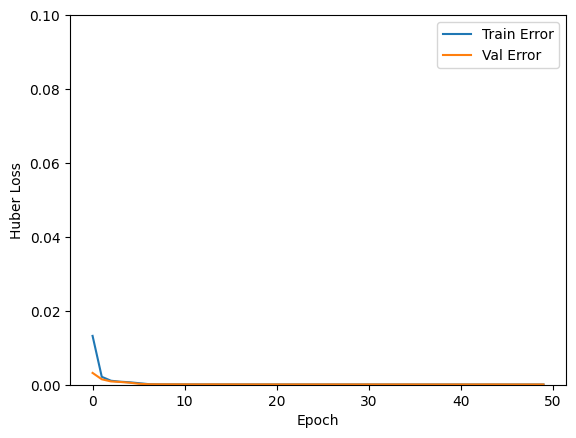

In [34]:
def plot_history(history, loss):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel(f'{loss} Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.ylim([0,0.1])
  plt.legend()
  plt.show()

plot_history(history, "Huber")

In [35]:
def plot_pred_vs_test(test, pred):
    columns = test.columns.tolist()
    max_list = []
    min_list = []
    mse_list = []
    perc_mse_list = []
    for column_num in range(len(columns)):
        plt.figure()
        plt.scatter(test.iloc[:,column_num], pred.iloc[:,column_num])

        #Getting important values
        minim = min(test.iloc[:,column_num])
        min_list.append(minim)
        maxim = max(test.iloc[:,column_num])
        max_list.append(maxim)
        mse = mean_squared_error(test.iloc[:,column_num], pred.iloc[:,column_num])
        mse_list.append(round(mse,6))
        rang = (maxim-minim)
        perc = mse/rang *100
        perc_mse_list.append(round(perc,6))
        title = columns[column_num] + " - mse: " + str(round(mse,6))
        plt.title(title)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        # Para tener una linea recta con la cual comparar los valores y que no altere
        # los limites de la figura se grafican los valores reales con ellos mismos
        plt.plot(test.iloc[:,column_num],test.iloc[:,column_num])
        plt.grid()
    data = {"Perception": columns, "Max.": max_list, "Min.": min_list, "Mse": mse_list, "Mse perc.": perc_mse_list}
    data_df = pd.DataFrame(data)
    return(data_df)

In [36]:
## Finalmente se hace uso de los datos de prueba para la predicción.
test_predictions = model.predict(X_test_scaled)
test_predictions_unscaled = scaler.inverse_transform(test_predictions)
df_test_predictions_unscaled = pd.DataFrame(test_predictions_unscaled)

275/275 [==============================] - 0s 827us/step


,Perception,Max.,Min.,Mse,Mse perc.
0,post_j_positions_0,1.571243,-1.570844,0.000346,0.011009
1,post_j_positions_1,1.570925,-1.570949,0.000096,0.003044
2,post_pos_x,-0.065530,-0.126130,0.000001,0.001233
3,post_pos_y,0.063935,-0.059991,0.000001,0.000843
4,post_pos_z,0.041188,0.030251,0.000000,0.000413


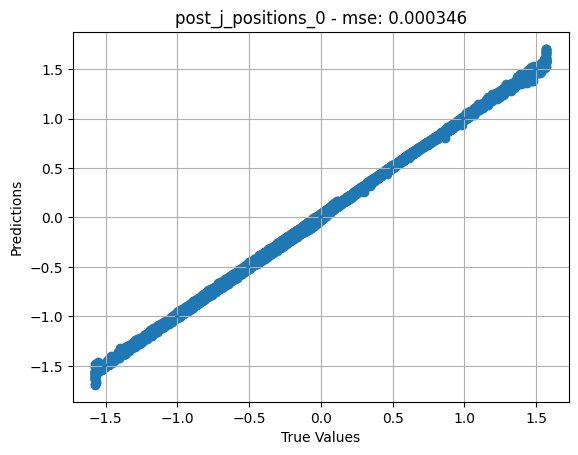

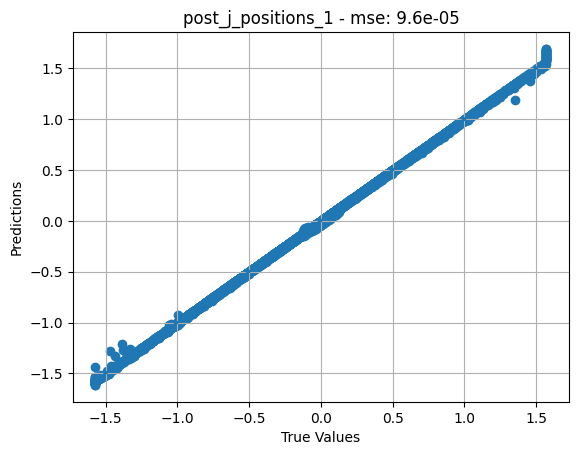

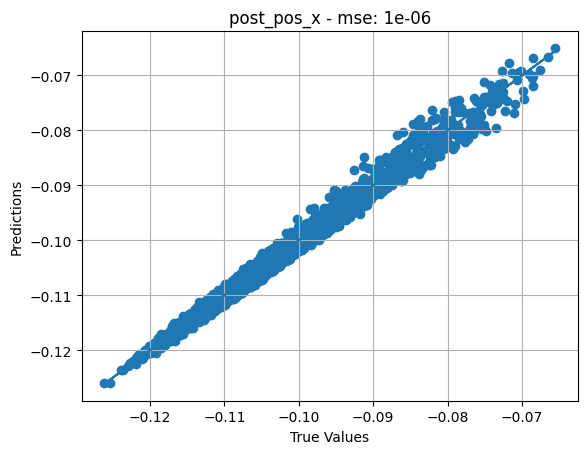

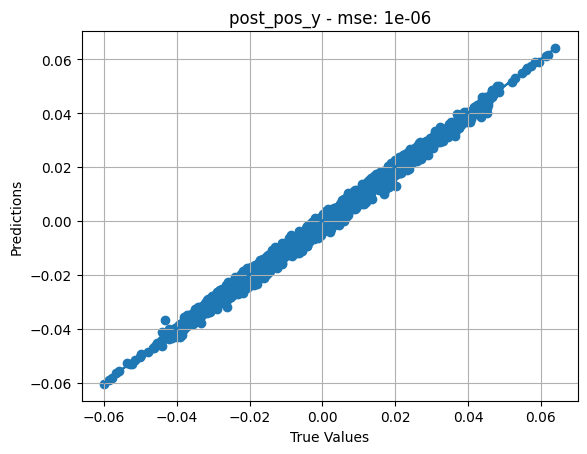

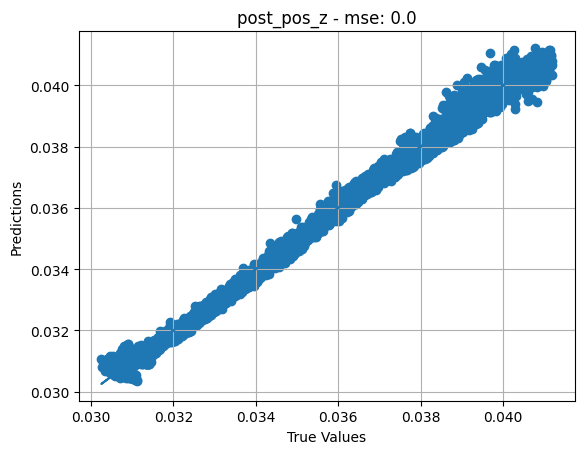

In [37]:
plot_pred_vs_test(y_test, df_test_predictions_unscaled)

In [38]:
timestr = time.strftime("_%Y_%d_%m")
model_name = "model_" + scene + timestr + ".keras"
print(model_name)
model.save("models\\" + model_name)

### Modular02b

Epoch 1/50
880/880 [==============================] - 1s 1ms/step - loss: 0.0161 - val_loss: 0.0071
Epoch 2/50
880/880 [==============================] - 1s 1ms/step - loss: 0.0046 - val_loss: 0.0025
Epoch 3/50
880/880 [==============================] - 1s 1ms/step - loss: 0.0015 - val_loss: 8.5302e-04
Epoch 4/50
880/880 [==============================] - 1s 1ms/step - loss: 7.5224e-04 - val_loss: 6.9948e-04
Epoch 5/50
880/880 [==============================] - 1s 1ms/step - loss: 7.0097e-04 - val_loss: 6.8498e-04
Epoch 6/50
880/880 [==============================] - 1s 1ms/step - loss: 6.9380e-04 - val_loss: 7.0977e-04
Epoch 7/50
880/880 [==============================] - 1s 1ms/step - loss: 6.7008e-04 - val_loss: 6.5361e-04
Epoch 8/50
880/880 [==============================] - 1s 1ms/step - loss: 6.0972e-04 - val_loss: 6.0905e-04
Epoch 9/50
880/880 [==============================] - 1s 1ms/step - loss: 5.7689e-04 - val_loss: 5.8069e-04
Epoch 10/50
880/880 [===========================

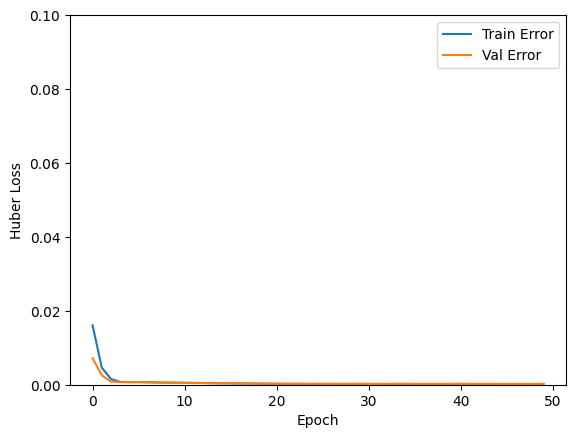

275/275 [==============================] - 0s 769us/step


,Perception,Max.,Min.,Mse,Mse perc.
0,post_j_positions_0,1.571444,-1.571017,0.000092,0.002927
1,post_j_positions_1,1.570872,-1.571543,0.000142,0.004528
2,post_pos_x,-0.055446,-0.140709,0.000001,0.001124
3,post_pos_y,0.004492,-0.004906,0.000000,0.000276
4,post_pos_z,0.043723,0.027380,0.000000,0.002977


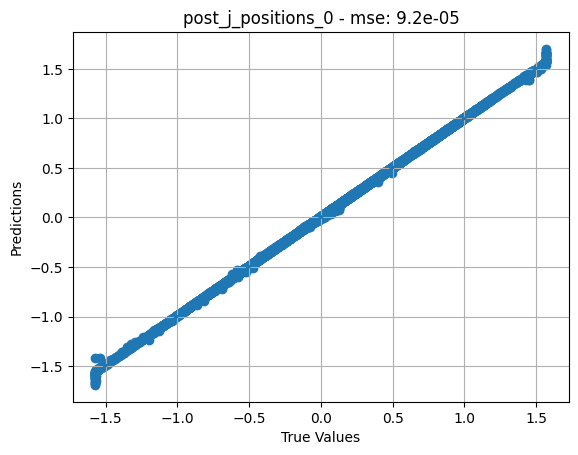

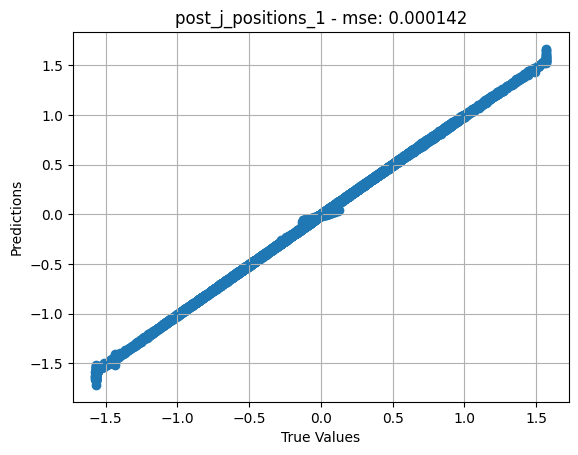

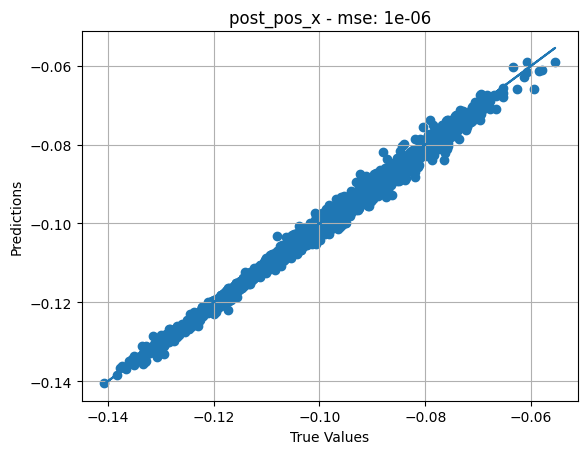

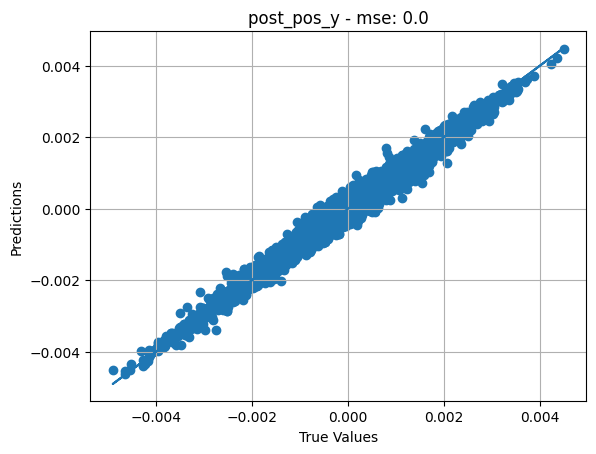

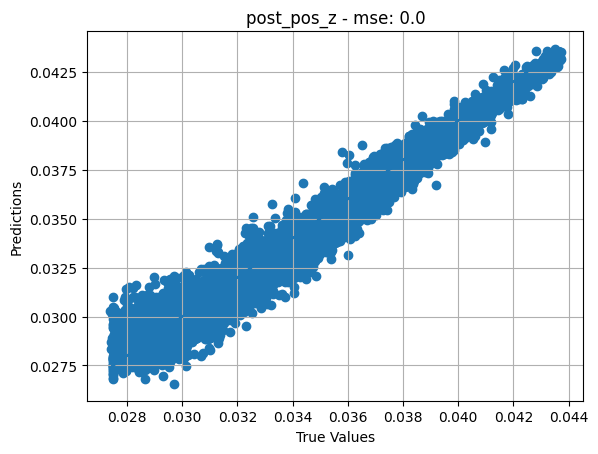

In [39]:
scene = "modular02b"
X, y =load_dataset(scene)

# Se separan los datos de entrenmiento (80%) y los de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=42
)

# Scaling de los datos 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

# Creacion y entrenamiento del modelo
model = Sequential()

# Capa de entrada con 22 unidades (correspondiente al número de entradas)
model.add(Dense(units=7, input_dim=7, activation='relu'))

# Capas ocultas con 64 unidades cada una
model.add(Dense(units=24, activation='relu'))

# Capa de salida con 14 unidades (correspondiente al número de salidas) y activación lineal
model.add(Dense(units=5, activation='linear'))

# Compilar el modelo con una función de pérdida adecuada para regresión
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=1.0))

# Supongamos que X_train y y_train son tus datos de entrenamiento
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2)

plot_history(history, "Huber")

## Finalmente se hace uso de los datos de prueba para la predicción.
test_predictions = model.predict(X_test_scaled)
test_predictions_unscaled = scaler.inverse_transform(test_predictions)
df_test_predictions_unscaled = pd.DataFrame(test_predictions_unscaled)

plot_pred_vs_test(y_test, df_test_predictions_unscaled)

In [40]:
timestr = time.strftime("_%Y_%d_%m")
model_name = "model_" + scene + timestr + ".keras"
print(model_name)
model.save("models\\" + model_name)

model_modular02b_2023_3010.keras


### Modular02c

Epoch 1/50
880/880 [==============================] - 2s 1ms/step - loss: 0.0124 - val_loss: 0.0031
Epoch 2/50
880/880 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 3/50
880/880 [==============================] - 1s 1ms/step - loss: 9.2190e-04 - val_loss: 7.9109e-04
Epoch 4/50
880/880 [==============================] - 1s 1ms/step - loss: 7.7175e-04 - val_loss: 7.1483e-04
Epoch 5/50
880/880 [==============================] - 1s 1ms/step - loss: 7.2848e-04 - val_loss: 6.8867e-04
Epoch 6/50
880/880 [==============================] - 1s 1ms/step - loss: 7.0580e-04 - val_loss: 6.7254e-04
Epoch 7/50
880/880 [==============================] - 1s 1ms/step - loss: 6.8827e-04 - val_loss: 7.5310e-04
Epoch 8/50
880/880 [==============================] - 1s 1ms/step - loss: 6.5952e-04 - val_loss: 6.1954e-04
Epoch 9/50
880/880 [==============================] - 1s 1ms/step - loss: 6.0581e-04 - val_loss: 6.1089e-04
Epoch 10/50
880/880 [=======================

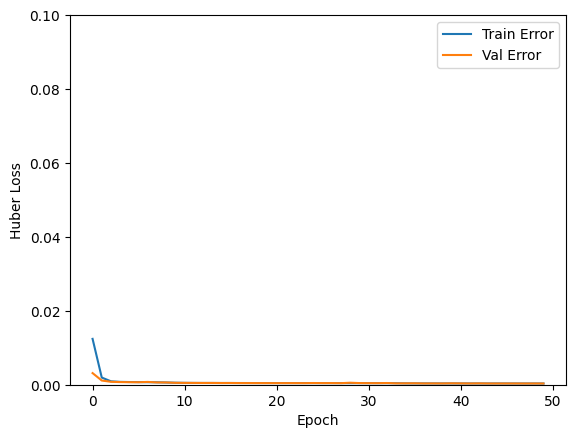

275/275 [==============================] - 0s 772us/step


,Perception,Max.,Min.,Mse,Mse perc.
0,post_j_positions_0,1.570798,-1.570877,0.000728,0.023173
1,post_j_positions_1,1.570834,-1.571314,0.001510,0.048064
2,post_pos_x,-0.021019,-0.104831,0.000002,0.002693
3,post_pos_y,-0.037271,-0.126711,0.000003,0.003220
4,post_pos_z,0.048053,0.027390,0.000001,0.004788


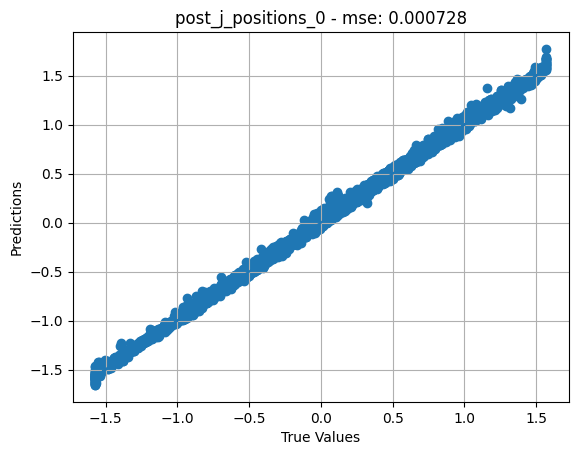

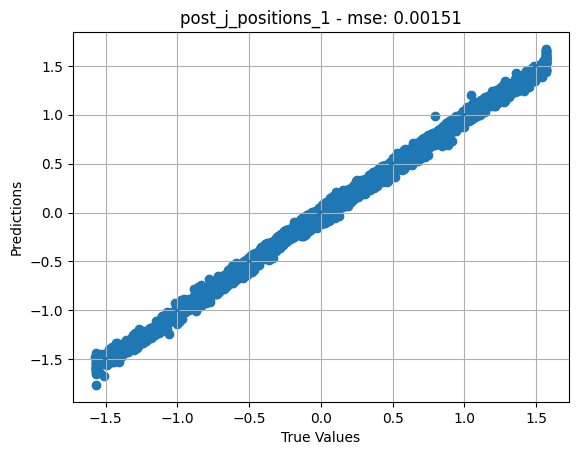

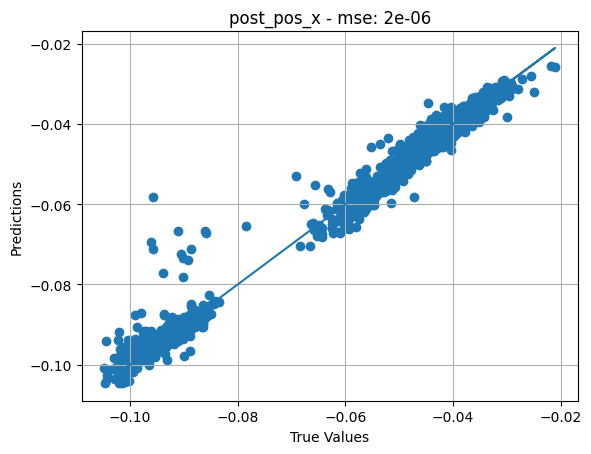

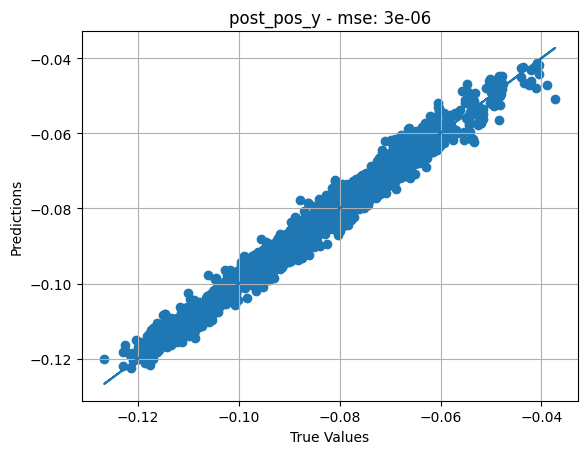

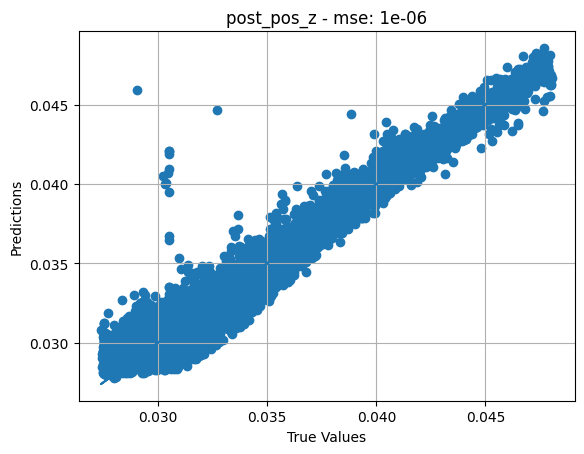

In [41]:
scene = "modular02c"
X, y =load_dataset(scene)

# Se separan los datos de entrenmiento (80%) y los de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=42
)

# Scaling de los datos 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

# Creacion y entrenamiento del modelo
model = Sequential()

# Capa de entrada con 22 unidades (correspondiente al número de entradas)
model.add(Dense(units=7, input_dim=7, activation='relu'))

# Capas ocultas con 64 unidades cada una
model.add(Dense(units=24, activation='relu'))

# Capa de salida con 14 unidades (correspondiente al número de salidas) y activación lineal
model.add(Dense(units=5, activation='linear'))

# Compilar el modelo con una función de pérdida adecuada para regresión
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=1.0))

# Supongamos que X_train y y_train son tus datos de entrenamiento
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2)

plot_history(history, "Huber")

## Finalmente se hace uso de los datos de prueba para la predicción.
test_predictions = model.predict(X_test_scaled)
test_predictions_unscaled = scaler.inverse_transform(test_predictions)
df_test_predictions_unscaled = pd.DataFrame(test_predictions_unscaled)

plot_pred_vs_test(y_test, df_test_predictions_unscaled)

In [42]:
timestr = time.strftime("_%Y_%d_%m")
models_path = "models\\" + timestr[1:]
if not os.path.exists(models_path):
    os.mkdir(models_path)
    print(f"Directorio '{models_path}' ha sido creado.")
else:
    print(f"El directorio '{models_path}' ya existe.")
model.save(models_path + "\\model_" + scene + timestr + ".keras")

model_modular02c_2023_3010.keras
